In [1]:
import sys
from pathlib import Path 
import pandas as pd
import duckdb

In [2]:
# Add utils path (from notebooks/ to src/utils)
sys.path.append(str((Path().resolve().parent / "src" / "utils").resolve()))
from load_data import load_csv, list_csv_files

# Set data directory to project_root/data/raw
project_root = Path().resolve().parent
data_dir = project_root / "data" / "raw"

# load orders.csv
df = load_csv("orders.csv", data_dir=data_dir)
if df is not None:
    display(df.head())
    display(df.tail()) 
    display(df.describe(include='all'))
    display(df.isnull().sum())
df.info()

✅ CSV loaded: C:\Users\mashel\Desktop\econ_churn\data\raw\orders.csv


,order_id,customer_id,product_id,order_date,quantity,price,discount,payment_method
0,ORD00001,CUST0023,PROD0044,2024-08-25,3,25.24,26.04,Gift Card
1,ORD00002,CUST0050,PROD0026,2024-12-18,1,109.66,24.18,Gift Card
2,ORD00003,CUST0041,PROD0036,2025-01-12,3,87.98,23.70,Apple Pay
3,ORD00004,CUST0164,PROD0041,2025-07-03,3,196.65,9.14,Gift Card
4,ORD00005,CUST0010,PROD0025,2025-01-30,1,31.29,2.43,Gift Card


,order_id,customer_id,product_id,order_date,quantity,price,discount,payment_method
995,ORD00996,CUST0089,PROD0020,2024-12-28,2,186.81,19.55,PayPal
996,ORD00997,CUST0138,PROD0034,2024-02-18,2,32.11,22.16,PayPal
997,ORD00998,CUST0088,PROD0013,2023-07-21,3,165.32,9.47,PayPal
998,ORD00999,CUST0099,PROD0013,2025-04-08,3,82.32,19.34,PayPal
999,ORD01000,CUST0175,PROD0048,2024-11-26,1,176.82,11.85,Gift Card


,order_id,customer_id,product_id,order_date,quantity,price,discount,payment_method
count,1000,1000,1000,1000,1000.000000,1000.000000,1000.000000,1000
unique,1000,199,50,560,NaN,NaN,NaN,4
top,ORD01000,CUST0050,PROD0008,2024-06-11,NaN,NaN,NaN,PayPal
freq,1,12,28,7,NaN,NaN,NaN,267
mean,NaN,NaN,NaN,NaN,1.964000,105.615660,14.956170,NaN
std,NaN,NaN,NaN,NaN,0.820596,55.259182,8.630078,NaN
min,NaN,NaN,NaN,NaN,1.000000,10.880000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,1.000000,55.340000,7.780000,NaN
50%,NaN,NaN,NaN,NaN,2.000000,107.970000,15.015000,NaN
75%,NaN,NaN,NaN,NaN,3.000000,152.622500,22.445000,NaN


order_id          0
customer_id       0
product_id        0
order_date        0
quantity          0
price             0
discount          0
payment_method    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        1000 non-null   object 
 1   customer_id     1000 non-null   object 
 2   product_id      1000 non-null   object 
 3   order_date      1000 non-null   object 
 4   quantity        1000 non-null   int64  
 5   price           1000 non-null   float64
 6   discount        1000 non-null   float64
 7   payment_method  1000 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 62.6+ KB


## Insights
- Order & Customer Structure
1000 unique orders (order_id), each appears only once.
199 unique customers (customer_id), with the most frequent customer making 12 orders.
50 unique products (product_id), with the most frequent product appearing in 28 orders.

- Order dates
560 unique order dates out of 1000 orders, with the most common date having 7 orders.
This suggests orders are spread over many days, with some days busier than others.

- Quantities
Mean quantity: ~2 per order (min 1, max 3, std ~0.82).
All quantities are positive (min is 1), so no negative or zero values.

- Prices
Mean price: ~$105.62 (min ~$10.88, max ~$199.89).
Wide price range (std ~$55.26), indicating a mix of low and high-value products.

- Discounts
Mean discount: ~$14.96 (min 0, max ~$29.95).
Discounts are always positive or zero (no negative discounts).
Discounts vary substantially (std ~8.63).

- Payment Methods
4 unique payment methods; the most common is PayPal (267 orders).

- General Observations
No missing values in these columns (all counts are 1000).
No negative or zero quantities/prices.
Some customers and products are much more active/frequent than others.
Discounts are used variably, with some orders having no discount and others up to ~$30.

In [3]:
df.dtypes

order_id           object
customer_id        object
product_id         object
order_date         object
quantity            int64
price             float64
discount          float64
payment_method     object
dtype: object

In [4]:
# Convert 'order_date' to datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%Y-%m-%d')

df.dtypes


order_id                  object
customer_id               object
product_id                object
order_date        datetime64[ns]
quantity                   int64
price                    float64
discount                 float64
payment_method            object
dtype: object

<Axes: title={'center': 'Unique Orders per Month'}, xlabel='order_month'>

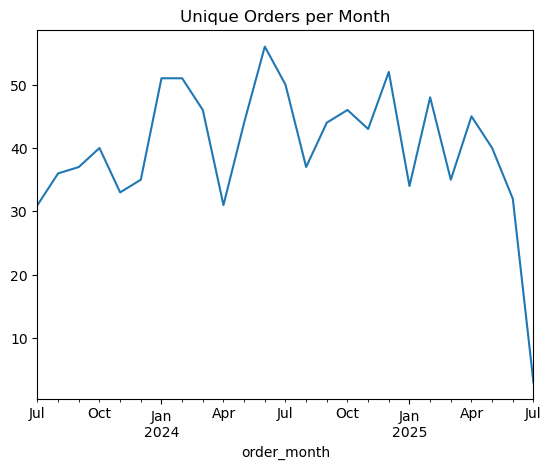

In [5]:
# monthly_revenue.plot(title="Revenue per Month")
df['order_month'] = df['order_date'].dt.to_period('M')
monthly_orders = df.groupby('order_month')['order_id'].nunique()
monthly_revenue = (df['quantity'] * df['price'] * (1 - df['discount'])).groupby(df['order_month']).sum()
monthly_orders.plot(title="Unique Orders per Month")
# monthly_revenue.plot(title="Revenue per Month")

<Axes: title={'center': 'Revenue per Month'}, xlabel='order_month'>

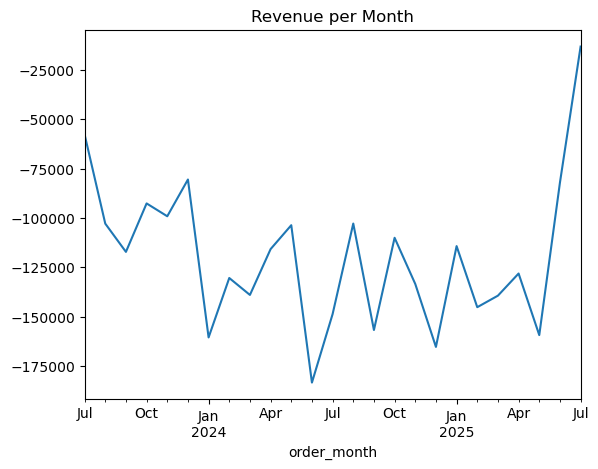

In [6]:
monthly_revenue.plot(title="Revenue per Month")

In [7]:
# 2. Top Customers by Revenue
df['total_price'] = df['quantity'] * df['price'] * (1 - df['discount'])
top_customers = df.groupby('customer_id')['total_price'].sum().sort_values(ascending=False).head(10)
display(top_customers)

customer_id
CUST0196    -720.0507
CUST0019    -911.1792
CUST0192   -1066.0011
CUST0100   -1166.7648
CUST0017   -1186.3804
CUST0068   -1292.3969
CUST0130   -1335.2400
CUST0106   -1581.3910
CUST0182   -1620.1718
CUST0134   -1760.4600
Name: total_price, dtype: float64

In [8]:
# 3. Top Products by Quantity Sold
top_products = df.groupby('product_id')['quantity'].sum().sort_values(ascending=False).head(10)
display(top_products)

product_id
PROD0004    56
PROD0037    55
PROD0030    53
PROD0040    53
PROD0023    52
PROD0008    51
PROD0017    50
PROD0021    49
PROD0038    49
PROD0018    48
Name: quantity, dtype: int64

<Axes: title={'center': 'Payment Method Distribution'}, xlabel='payment_method'>

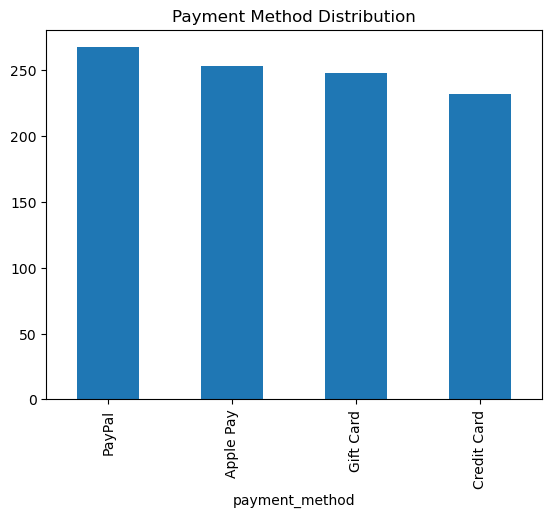

In [9]:
# 4. Payment Method Distribution
payment_counts = df['payment_method'].value_counts()
payment_counts.plot(kind='bar', title="Payment Method Distribution")

In [10]:
#Average Discount per Product
avg_discount = df.groupby('product_id')['discount'].mean().sort_values(ascending=False).head(10)
display(avg_discount)

product_id
PROD0005    19.675000
PROD0025    18.971579
PROD0046    18.621905
PROD0010    18.574444
PROD0032    17.972941
PROD0035    17.306000
PROD0049    17.275789
PROD0017    16.941852
PROD0001    16.862941
PROD0023    16.858800
Name: discount, dtype: float64

In [11]:
# 6. Orders per Customer (Frequency)
orders_per_customer = df.groupby('customer_id')['order_id'].nunique()
orders_per_customer.describe()

count    199.000000
mean       5.025126
std        2.295004
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: order_id, dtype: float64

In [12]:
# 7. Outlier Detection: Negative or Zero Quantity/Price
anomalies = df[(df['quantity'] <= 0) | (df['price'] <= 0)]
display(anomalies)

,order_id,customer_id,product_id,order_date,quantity,price,discount,payment_method,order_month,total_price


In [13]:
df.describe(include='all')

,order_id,customer_id,product_id,order_date,quantity,price,discount,payment_method,order_month,total_price
count,1000,1000,1000,1000,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000
unique,1000,199,50,NaN,NaN,NaN,NaN,4,25,NaN
top,ORD01000,CUST0050,PROD0008,NaN,NaN,NaN,NaN,PayPal,2024-06,NaN
freq,1,12,28,NaN,NaN,NaN,NaN,267,56,NaN
mean,NaN,NaN,NaN,2024-07-07 14:18:14.400000,1.964000,105.615660,14.956170,NaN,NaN,-2980.177412
min,NaN,NaN,NaN,2023-07-04 00:00:00,1.000000,10.880000,0.000000,NaN,NaN,-16393.939200
25%,NaN,NaN,NaN,2024-01-24 06:00:00,1.000000,55.340000,7.780000,NaN,NaN,-4226.810400
50%,NaN,NaN,NaN,2024-07-04 12:00:00,2.000000,107.970000,15.015000,NaN,NaN,-1917.754700
75%,NaN,NaN,NaN,2024-12-25 00:00:00,3.000000,152.622500,22.445000,NaN,NaN,-676.287900
max,NaN,NaN,NaN,2025-07-03 00:00:00,3.000000,199.890000,29.950000,NaN,NaN,304.076000


## Feature Engineering
- Add total_price

In [14]:
df['total_price'] = df['quantity'] * (df['price'] - df['discount'])
df['total_price'].describe()

count    1000.000000
mean      177.522330
std       138.887764
min       -44.640000
25%        67.305000
50%       144.235000
75%       268.180000
max       583.020000
Name: total_price, dtype: float64

In [15]:
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['weekday'] = df['order_date'].dt.day_name()


- Add order_quarter

In [16]:
df['order_quarter'] = df['order_date'].dt.to_period('Q').astype(str)

In [17]:
df.describe(include='all')
df.isnull().sum()
df['total_price'].describe()


count    1000.000000
mean      177.522330
std       138.887764
min       -44.640000
25%        67.305000
50%       144.235000
75%       268.180000
max       583.020000
Name: total_price, dtype: float64

In [21]:
# Add utility path to sys
sys.path.append(str((Path().resolve().parent / "src" / "utils").resolve()))

# Import all utility functions you need
from load_data import save_csv 

# Save your cleaned DataFrame

print(df.shape) # ensure the DataFrame is not empty before saving
save_csv(df, "orders_clean.csv")


(1000, 14)
💾 Saved CSV to: C:\Users\mashel\Desktop\econ_churn\data\processed\orders_clean.csv


In [19]:
# List all CSV files in the data/raw directory
list_csv_files()

📄 Found CSV files: ['campaigns.csv', 'customers.csv', 'orders.csv', 'products.csv', 'returns.csv', 'reviews.csv', 'sessions.csv']


['campaigns.csv',
 'customers.csv',
 'orders.csv',
 'products.csv',
 'returns.csv',
 'reviews.csv',
 'sessions.csv']